# Energy A.I. Hackathon 2021 Workflow - Team Anticline
## Prediction
#### Authors: Esmail Eltahan, Jeon Jonghyeon, Mehran Mehrabi, and Wen Pan, Hildebrand Department of Petroleum and Geosystems Engineering. 
#### The University of Texas at Austin, Austin, Texas USA 

<img src="anticline_official_logo.png" width=300 />



## Building ML Model 

Here, we build a ML model to predict the first year production.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns       #

## Load the data 



In [2]:
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")

df_production = pd.read_csv('production_history.csv')
df_p = pd.read_csv('./preprocessed_data/df_p_preprocessed_{0:03d}.csv'.format(0))
df_n = pd.read_csv('./preprocessed_data/df_n_preprocessed_{0:03d}.csv'.format(0))
df_merged = pd.read_csv('./preprocessed_data/df_merged_{0:03d}.csv'.format(0))


## Set up random forest



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, ExtraTreesRegressor
from sklearn import metrics
sns.set(font_scale = 3)

def regress_rf(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)
        

#         print("Training data set size: ",y_train.shape[0])
#         print("Testing data set size: ",y_test.shape[0])

        regressor = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # feature importance
#     # Get numerical feature importances
#     feature_names = X_variables.columns
#     feature_list = list(X_variables.columns)
#     importances = list(rf.feature_importances_)

#     # List of tuples with variable and importance
#     feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

#     # Print out the feature and importances
#     [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=150)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    
    # plotting feature importance
    # Import matplotlib for plotting and use magic command for Jupyter Notebooks

    # list of x locations for plotting
#     plt.figure()
#     x_values = list(range(len(importances)))
#     # Make a bar chart
#     plt.barh(x_values,importances, orientation = 'horizontal')#
#     # Tick labels for x axis
#     plt.yticks(x_values,feature_list )#, rotation='vertical'
#     # Axis labels and title
#     plt.ylabel(''); plt.xlabel('Importance'); plt.title('Variable Importances');
#     plt.savefig(
#         "Importances_randomforest.png",
#         bbox_inches='tight', dpi=200)
#     plt.show()
    
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

## Set up linear regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

def regress_linear(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)


        regressor = LinearRegression()

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))


    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=200)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))
    
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

    if shap:
        #SHAP ###
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=150)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

## Set up SVR

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def regress_svr(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    sc_X.fit(X_variables.values)
    means_X = sc_X.mean_ 
    vars_X = sc_X.var_  
    sc_y.fit(y_variable.values.reshape(-1, 1))
    means_y = sc_y.mean_ 
    vars_y = sc_y.var_ 
    X = sc_X.transform(X_variables.values)
    y = sc_y.transform(y_variable.values.reshape(-1, 1))
    
    np.random.seed(1)
    NN =10
    for i in range(NN):
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1), test_size = 0.3)

        regressor = SVR(kernel = 'rbf', C = 10, gamma='auto', epsilon = 0.1)
        regressor.fit(X_train, y_train)
        
        y_pred_test = regressor.predict(X_test)
        y_pred_train = regressor.predict(X_train)
        
        y_pred_test = sc_y.inverse_transform(y_pred_test).reshape(-1)
        y_pred_train = sc_y.inverse_transform(y_pred_train).reshape(-1)
        y_train = sc_y.inverse_transform(y_train).reshape(-1)
        y_test = sc_y.inverse_transform(y_test).reshape(-1)
        
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=150)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
 
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        return regressor

In [6]:
df_merged.columns

Index(['Well_ID', 'X', 'Y', 'Depth', 'Porosity', 'Perm', 'AI', 'Density',
       'Comp_vel', 'E', 'Vs', 'G', 'layer', 'lith_id', 'Log_perm', 'mindist',
       'avg_inv_dist', 'avg_sq_inv_dist', 'avg_sqrt_inv_dist', 'log_mindist',
       'Top_depth', 'interval', 'distance to woc', 'location',
       'distance to fault', 'fault indicator', 'Avg_perm', 'thickness',
       'bottom to woc', 'sand prp.', 'sandshaly prp.', 'k/log_mindist',
       'area_poly', 'woc rise 0', 'woc rise 1', 'woc rise 2', 'woc rise 3',
       'bottom to woc 1', 'bottom to woc 2', 'bottom to woc 3', 'Cumoil1',
       'Cumoil2', 'Cumoil3', 'Cumwater1', 'Cumwater2', 'Cumwater3', 'total1',
       'total2', 'total3', 'prod_o1', 'prod_o2', 'prod_o3', 'prod_w1',
       'prod_w2', 'prod_w3', 'oil12', 'oil23', 'water12', 'water23', 'wcut1',
       'wcut2', 'wcut3', 'wcutincrease1', 'wcutincrease2', 'dp_1', 'dp_2',
       'dp_3'],
      dtype='object')

## Total production regression

Features size:  (73, 5)

METRICS FOR TESTING DATA:

Mean Absolute Error: 165.237429657197
Mean Squared Error: 48156.92361511341
Root Mean Squared Error: 219.4468582940148
R-Squared: 0.615952194023059
Explained variance: 0.6161771463864583

METRICS FOR TRAINING DATA:

Mean Absolute Error: 44.51214336601299
Mean Squared Error: 4393.559673022762
Root Mean Squared Error: 66.28393223868633
R-Squared: 0.9557592784519041
Explained variance: 0.9557592784519041


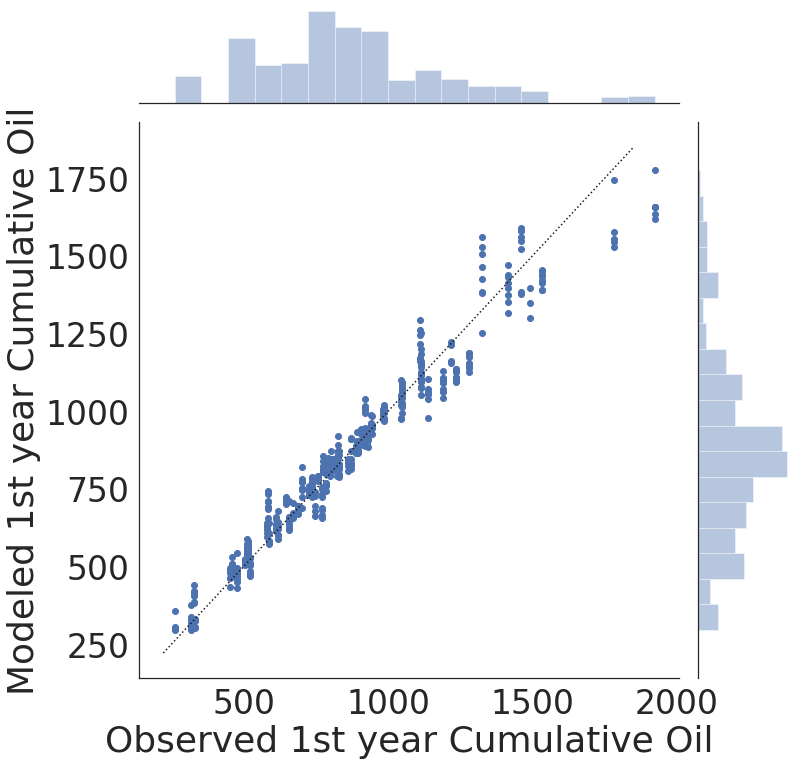

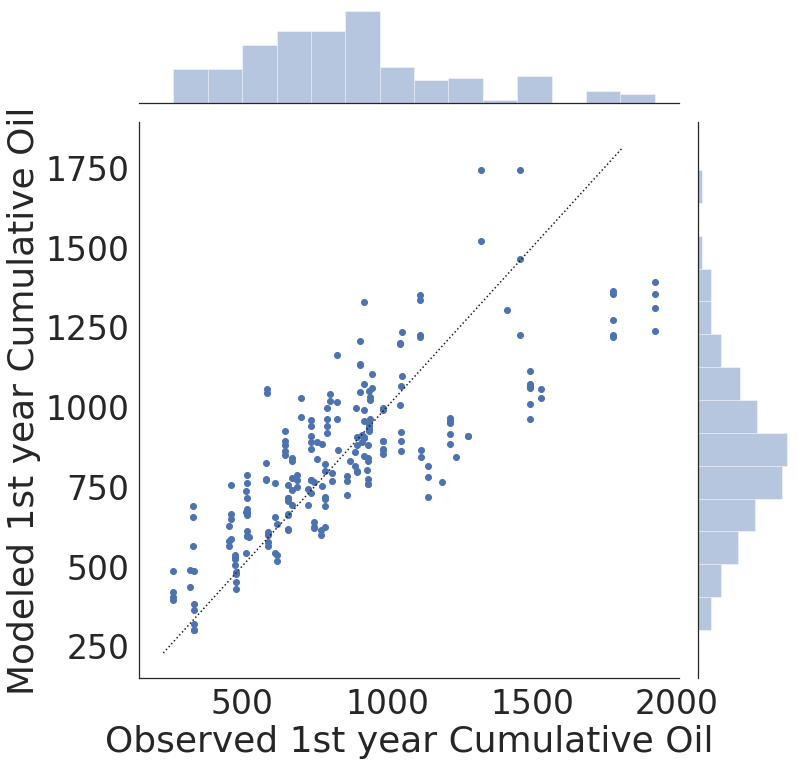

In [7]:
X_total = df_merged[[ "Porosity", "Perm",  'sand prp.', 'bottom to woc', 'avg_inv_dist']]
y_total = df_merged['total1']
label = '1st year Cumulative Oil'

regressor_total1 = regress_rf(X_total, y_total, label)

## Water cut regression

Features size:  (73, 4)

METRICS FOR TESTING DATA:

Mean Absolute Error: 0.04493959952572153
Mean Squared Error: 0.0031431526364058123
Root Mean Squared Error: 0.056063826451695324
R-Squared: 0.8637016657368524
Explained variance: 0.863902335201614

METRICS FOR TRAINING DATA:

Mean Absolute Error: 0.01184791747941823
Mean Squared Error: 0.0002677211172181898
Root Mean Squared Error: 0.016362185588062184
R-Squared: 0.9864650809998692
Explained variance: 0.9864650809998692


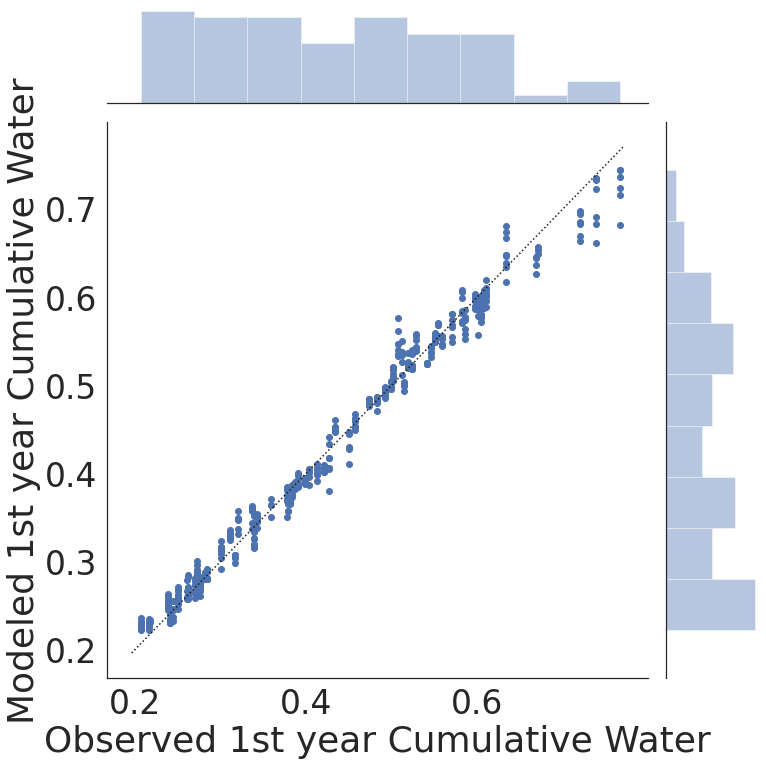

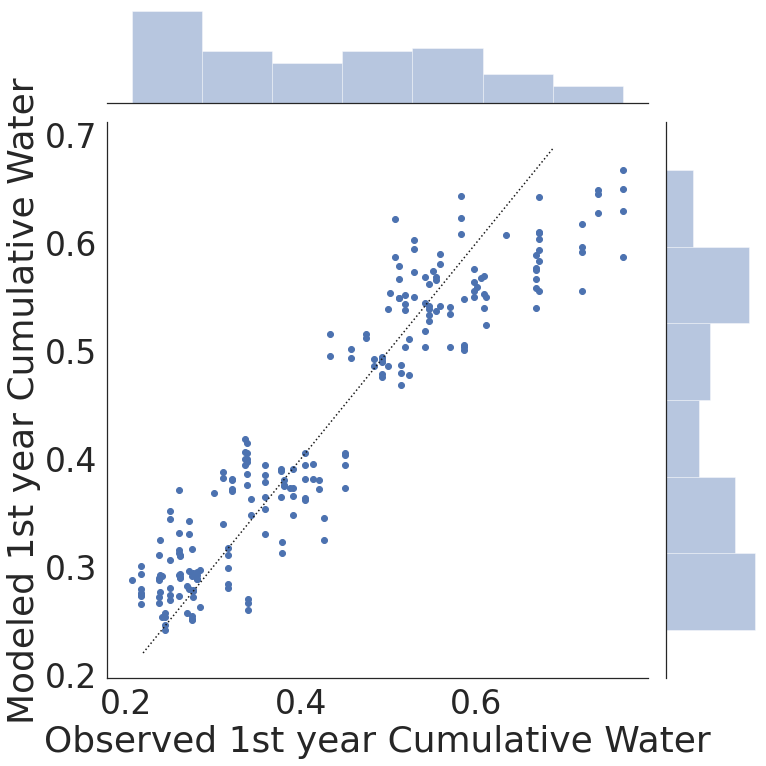

In [8]:
X_wcut = df_merged[[ "Porosity", "Perm", 'log_mindist', 'bottom to woc']]
y_wcut = df_merged['wcut1']
label = '1st year Cumulative Water'
regressor_wcut = regress_rf(X_wcut, y_wcut, label)

Features size:  (73, 2)

METRICS FOR TESTING DATA:

Mean Absolute Error: 35.7649065071929
Mean Squared Error: 2050.243129457111
Root Mean Squared Error: 45.279610526782484
R-Squared: 0.9873421519604495
Explained variance: 0.9873436160927788

METRICS FOR TRAINING DATA:

Mean Absolute Error: 35.747958937328946
Mean Squared Error: 2058.7474141617176
Root Mean Squared Error: 45.373421891694676
R-Squared: 0.9891817867790302
Explained variance: 0.9891817867790302


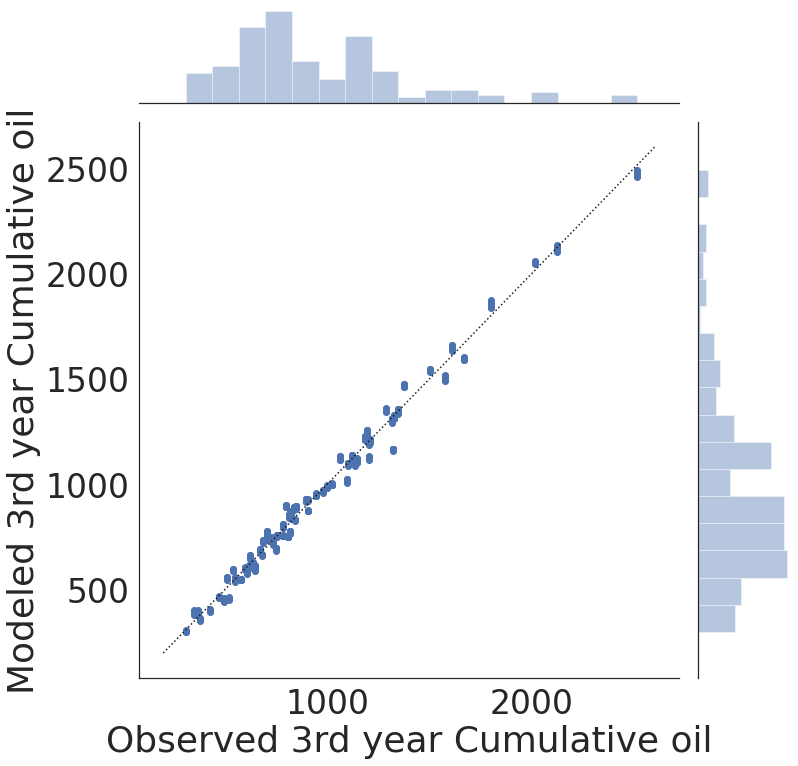

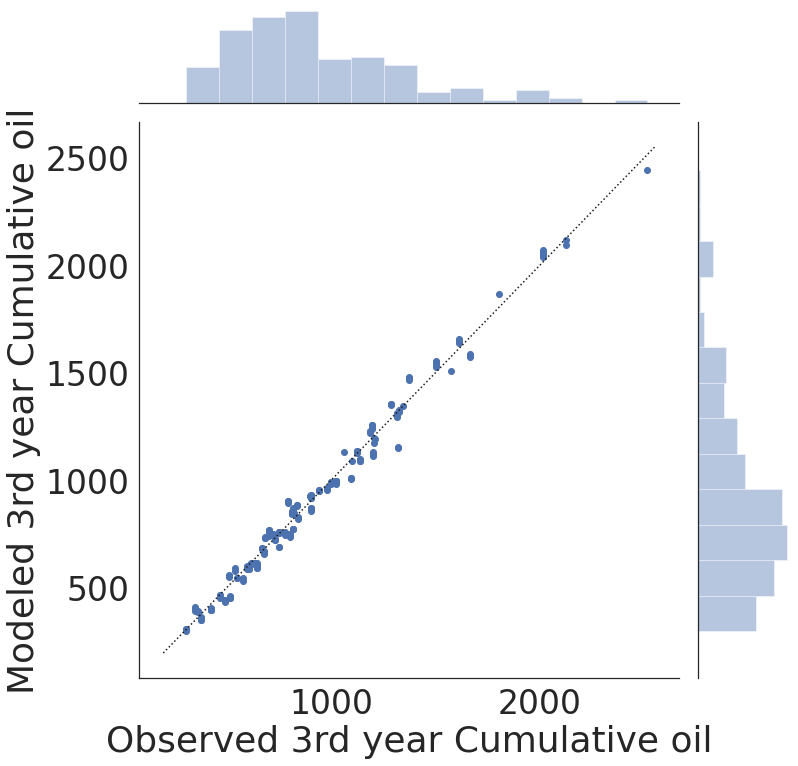

[  1.92876775 158.01587563] -58.90091882716547


In [9]:
X = df_merged[[ "Cumoil1", "wcut1"]]
y = df_merged['Cumoil3']
label = '3rd year Cumulative oil'
regressor_13 = regress_linear(X, y, label)
slope, intercept = regressor_13.coef_ , regressor_13.intercept_ 
print(slope, intercept)

In [10]:
y_pred = X_wcut*slope + intercept

plt.figure(dpi=200)
plt.plot(X_wcut, y_pred, 'k', label='Linear fit $R^2=0.87$, \n $y={0:.3f}x+{1:.3f}$'.format(slope[0], intercept))
plt.plot(X_wcut, y_wcut, 'o', color ='tab:blue', label='1st year data')
plt.xlabel("WOC to bottom depth (m)")
plt.ylabel("Water cut")
plt.legend()
plt.show()

ValueError: Unable to coerce to Series, length must be 4: given 2

In [ ]:
X_wcut = df_merged[[  'bottom to woc']]
y_wcut = df_merged['wcut1']
label = '1st year water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)
regressor_wcut.get_params()

In [ ]:
y_pred = X_wcut*slope + intercept
plt.figure(dpi=200)
plt.plot(X_wcut, y_pred, 'k', label='Linear fit $R^2=0.87$, \n $y={0:.3f}x+{1:.3f}$'.format(slope[0], intercept))
plt.plot(X_wcut, y_wcut, 'o', color ='tab:blue', label='1st year data')
plt.xlabel("WOC to bottom depth (m)")
plt.ylabel("Water cut")
plt.legend()
plt.show()

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc 1']].values, df_merged[['bottom to woc 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc 1']].values, df_merged[['bottom to woc 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc', 'woc rise 0']].values, df_merged[['bottom to woc', 'woc rise 1']].values, df_merged[['bottom to woc', 'woc rise 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)


In [ ]:

X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc']].values, df_merged[['bottom to woc']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

## Function to calculate 1st year oil prod

we basically form a pipeline that has a machine learning model that predicts water cut and total and then calculate oil.

In [ ]:
def calculate_cum1(X_total, X_wcut, total, wcut, oil, label):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(1)
    for i in range(10):
        X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
        train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
        regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
        regressor_total.fit(X_total_train, total_train)
        total_predict_test = regressor_total.predict(X_total_test)
        del regressor_total
        regressor_wcut = LinearRegression()
        regressor_wcut.fit(X_wcut_train, wcut_train)     
        wcut_predict_test = regressor_wcut.predict(X_wcut_test)
        del regressor_wcut
        oil_predict_test = total_predict_test*(1-wcut_predict_test)
        oil_tests.append(oil_test)
        oil_predict_tests.append(oil_predict_test)
#         print(oil_test.shape == oil_predict_test.shape)
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    print(oil_tests.shape)
    print(oil_predict_tests.shape)

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    

In [ ]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm",  'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil1']
label = '1st year cumulative oil'
calculate_cum1(X_total, X_wcut, y_total, y_wcut, y_oil, label)

## Function to calculate 3rd year oil prod

we basically form a pipeline that has a machine learning model that predicts water cut and total and then calculate oil.

In [25]:
def train_cum3(X_total, X_wcut, total, wcut, oil, label, regressor13, method='rf'):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(1)
    for i in range(10):
        X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
        train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
        if method == 'rf':
            regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
        if method == 'linear':
            regressor_total = LinearRegression()
        regressor_total.fit(X_total_train, total_train)
        total_predict_test = regressor_total.predict(X_total_test)
        del regressor_total
        regressor_wcut = LinearRegression()
        regressor_wcut.fit(X_wcut_train, wcut_train)     
        wcut1_predict_test = regressor_wcut.predict(X_wcut_test)
        del regressor_wcut
        oil1_predict_test = total_predict_test*(1-wcut1_predict_test) # 1st year oil
        
        oil_predict_test = regressor13.predict(np.array([oil1_predict_test,wcut1_predict_test]).T) ## 3rd year cum
        
        oil_tests.append(oil_test)
        oil_predict_tests.append(oil_predict_test)
#         print(oil_test.shape == oil_predict_test.shape)
        
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    print(oil_tests.shape)
    print(oil_predict_tests.shape)

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    

(220,)
(220,)

METRICS FOR TESTING DATA:

Mean Absolute Error: 186.29307278471987
Mean Squared Error: 57225.97574024331
Root Mean Squared Error: 239.21951371124243
R-Squared: 0.7256767944341408
Explained variance: 0.7297790149825206


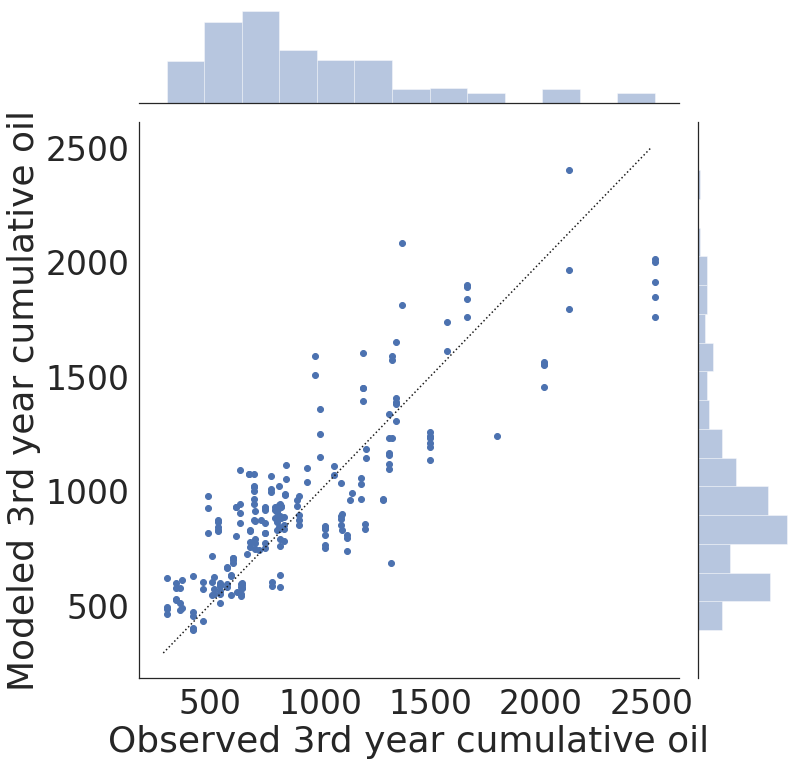

In [26]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
train_cum3(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf')

In [13]:
def regress_cum3(X_total, X_wcut, total, wcut, oil, label, regressor13, method='rf'):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(4)
    
    X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
    train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
    if method == 'rf':
        regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                               min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
    if method == 'linear':
        regressor_total = LinearRegression()
    regressor_total.fit(X_total_train, total_train)
    total_predict_test = regressor_total.predict(X_total_test)
    regressor_wcut = LinearRegression()
    regressor_wcut.fit(X_wcut_train, wcut_train)     
    wcut1_predict_test = regressor_wcut.predict(X_wcut_test)
    oil1_predict_test = total_predict_test*(1-wcut1_predict_test) # 1st year oil

    oil_predict_test = regressor13.predict(np.array([oil1_predict_test,wcut1_predict_test]).T) ## 3rd year cum

    oil_tests.append(oil_test)
    oil_predict_tests.append(oil_predict_test)
#         print(oil_test.shape == oil_predict_test.shape)
        
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    print(oil_tests.shape)
    print(oil_predict_tests.shape)

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    return regressor_total, regressor_wcut, regressor13




In [14]:
def predict_cum3_final(X_total, X_wcut,label, regressor_total, regressor_wcut, regressor13, method='rf'):

    total_predict = regressor_total.predict(X_total)
    wcut1_predict = regressor_wcut.predict(X_wcut)
    oil_1_predict = total_predict*(1-wcut1_predict) # 1st year oil
    oil_predict = regressor13.predict(np.array([oil_1_predict,wcut1_predict]).T) ## 3rd year cum        
    

    return oil_predict




Features size:  (73, 2)

METRICS FOR TESTING DATA:

Mean Absolute Error: 35.7649065071929
Mean Squared Error: 2050.243129457111
Root Mean Squared Error: 45.279610526782484
R-Squared: 0.9873421519604495
Explained variance: 0.9873436160927788

METRICS FOR TRAINING DATA:

Mean Absolute Error: 35.747958937328946
Mean Squared Error: 2058.7474141617176
Root Mean Squared Error: 45.373421891694676
R-Squared: 0.9891817867790302
Explained variance: 0.9891817867790302


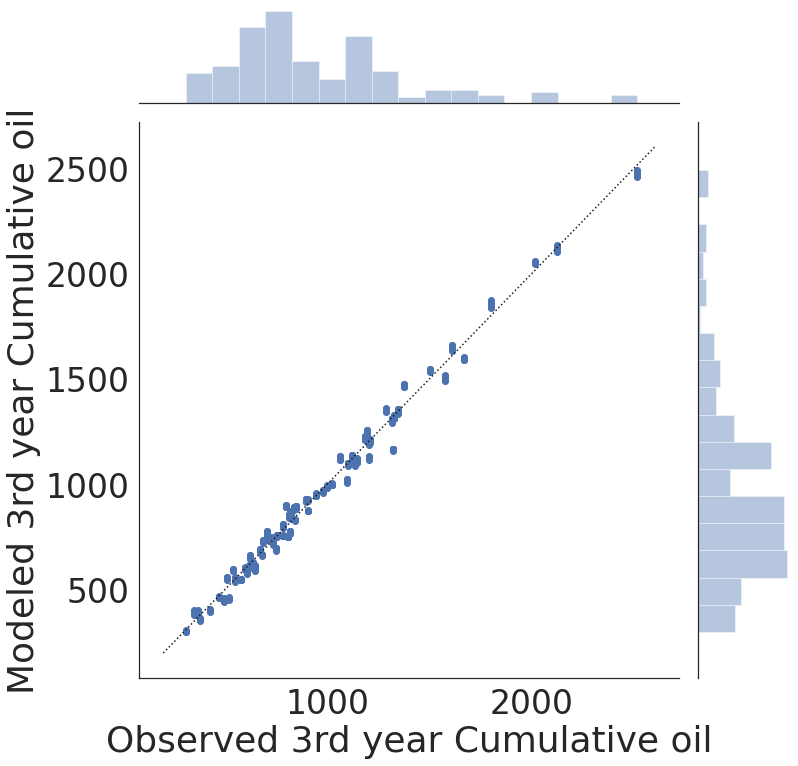

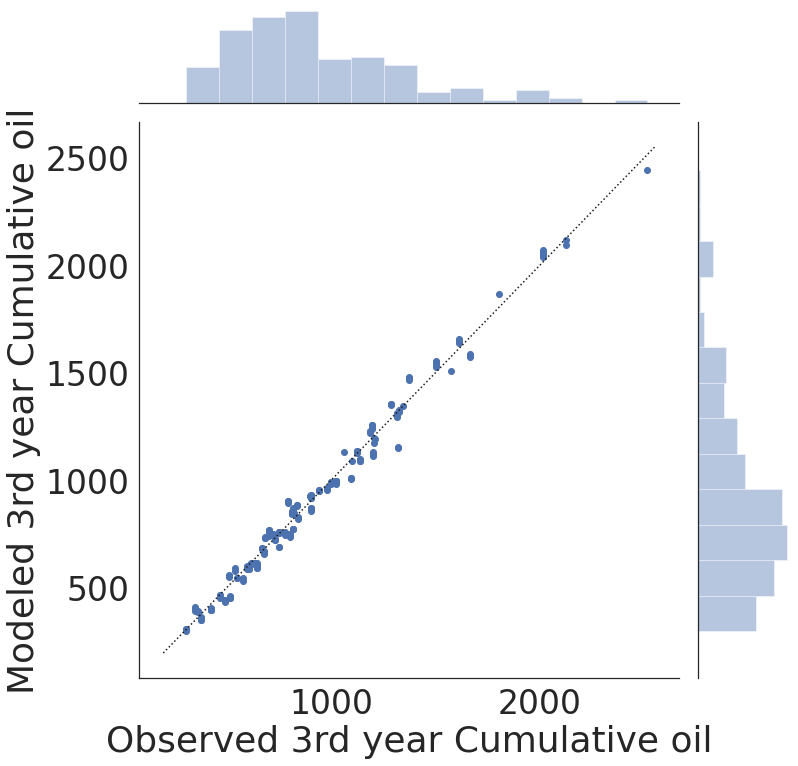

[  1.92876775 158.01587563] -58.90091882716547


In [15]:
X = df_merged[[ "Cumoil1", "wcut1"]]
y = df_merged['Cumoil3']
label = '3rd year Cumulative oil'
regressor_13 = regress_linear(X, y, label)
slope, intercept = regressor_13.coef_ , regressor_13.intercept_ 
print(slope, intercept)

(22,)
(22,)

METRICS FOR TESTING DATA:

Mean Absolute Error: 150.82188403145295
Mean Squared Error: 41773.35220405363
Root Mean Squared Error: 204.38530329760414
R-Squared: 0.7293010594283784
Explained variance: 0.7423774039117317


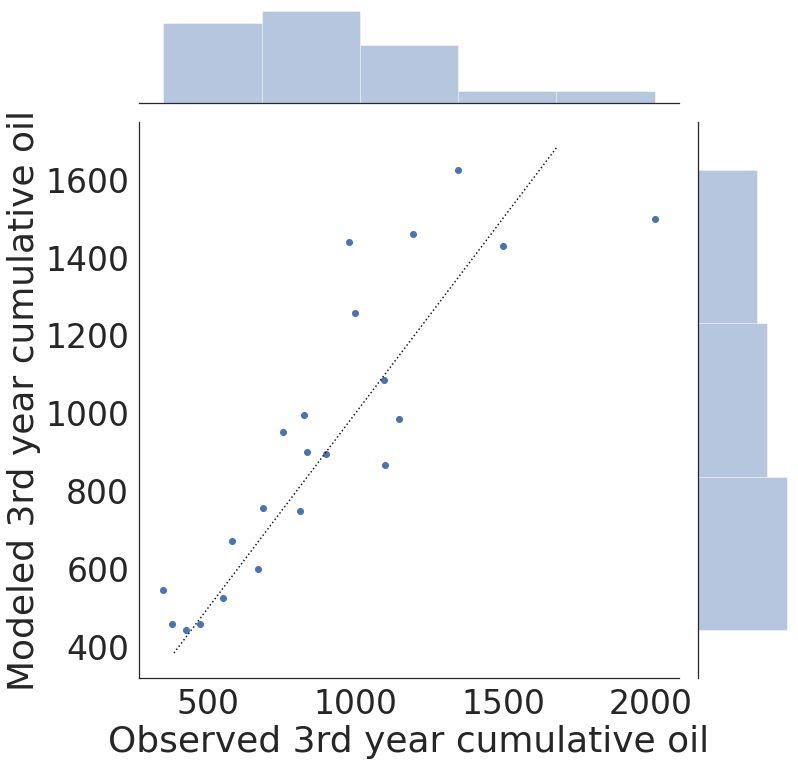

In [21]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
regressor_total, regressor_wcut, regressor13 = regress_cum3(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf')
# new wells predictions
X_wcut = df_n[['bottom to woc']]
X_total = df_n[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]

predictions = predict_cum3_final(X_total, X_wcut,label, regressor_total, regressor_wcut, regressor13, method='rf')

In [27]:
final_predictions = predictions
df_n['Cumoil3'] = predictions
predictions

array([1056.35796632,  963.45155406, 1238.46851454, 1555.09279934,
        974.4328886 , 1007.31000091,  925.81896856,  906.64135223,
       1300.49448725,  883.95773154])

In [11]:
df_n.shape

(10, 40)

In [28]:
true_oils = np.array([720, 1020, 1050, 1170, 1180, 1350, 1390, 1550, 1570, 1650])

In [31]:
np.mean((predictions - true_oils)**2)

174867.3884162523